# Исследование точности предсказаний сверточных нейронных сетей на примере распознавания цифр

импортируемые библиотеки

In [ ]:
import warnings
from typing import Union

import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader

!pip install torchinfo
from torchinfo import summary

from typing import List, Dict

from collections import defaultdict

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from tqdm import tqdm

from torchvision import datasets, transforms

import os
from google.colab import files

from pathlib import Path


cuda


Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
# Классы объектов в датасете
num_classes = 10
classes_list = [str(i) for i in range(num_classes)]

Визуализируем несколько картинок с соответствующими метками из датасета.

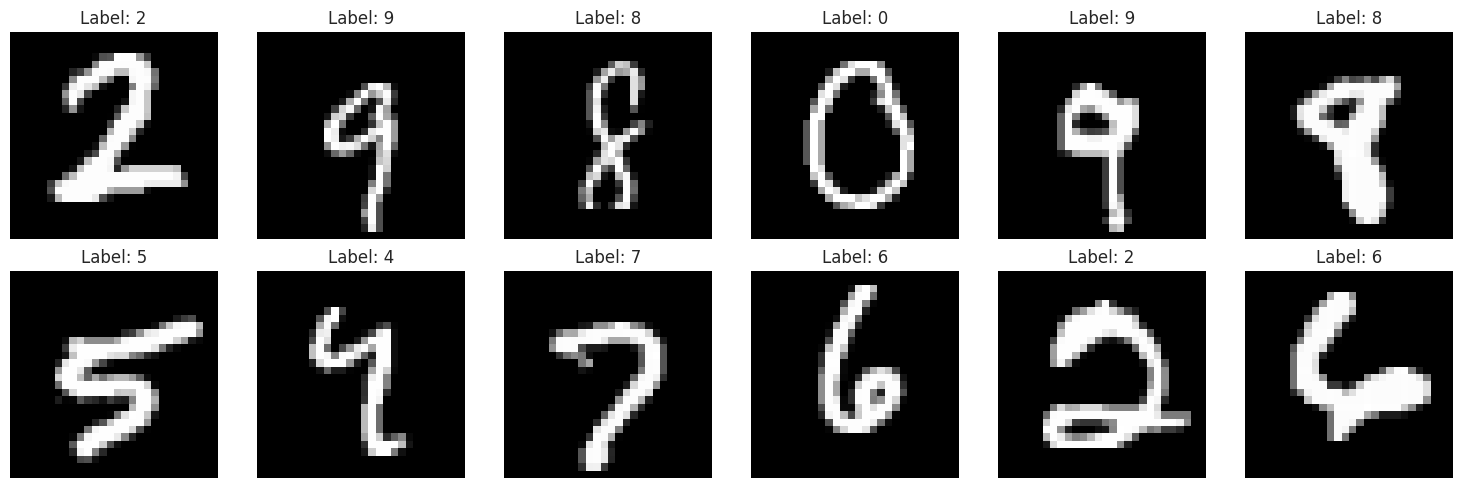

In [ ]:
def visualize_samples(dataset, num_samples=12):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        plt.subplot(2, 6, i+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

Создадим генераторы батчей.

In [ ]:

# Размер батча
batch_size = 64

# Генератор батчей для обучения
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Генератор батчей для тестирования
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

инициализируем несколько моделей для исследования 

In [ ]:
# Определение 5 различных моделей
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

выведем информацию и моделях

In [ ]:
# Вывод информации о моделях
models = [CNN1(), CNN2(), CNN3(), CNN4(), CNN5()]
for i, model in enumerate(models, 1):
    print(f"Model CNN{i} Summary:")
    print(summary(model, input_size=(1, 1, 28, 28), verbose=1))
    print("\n" + "-"*50 + "\n")


Model CNN1 Summary:
Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─Linear: 1-2                            [1, 10]                   125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.50
Estimated Total Size (MB): 0.61
Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─Linear: 1-2                            [1, 10]                   125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10

обучим модели

для удобства обернем обучение в универсальную функцию

In [ ]:
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    history = {"loss": {"train": [], "val": []}, "acc": {"train": [], "val": []}}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        history["loss"]["train"].append(train_loss / len(train_loader))
        history["acc"]["train"].append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        history["loss"]["val"].append(val_loss / len(val_loader))
        history["acc"]["val"].append(correct / total)

    return history

models = [CNN1(), CNN2(), CNN3(), CNN4(), CNN5()]
names = ["CNN1", "CNN2", "CNN3", "CNN4", "CNN5"]
histories = [train_model(model, train_loader, val_loader) for model in models]


построим график лосса всех моделей

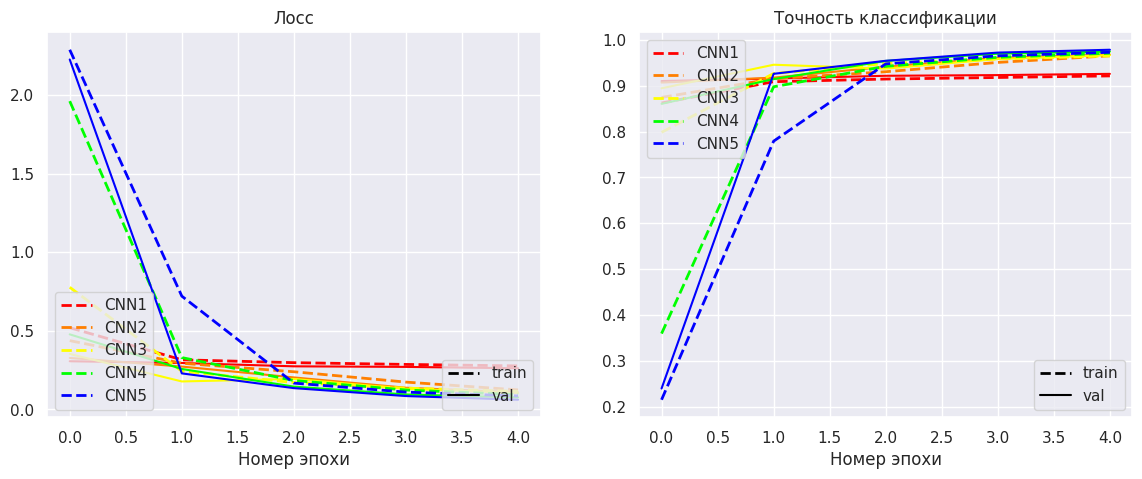

In [ ]:
def plot_histories(histories: List[Dict[str, Dict[str, list]]], names: List[str]) -> None:
    """
    Визуализирует лосс и точность для нескольких моделей на одном графике.

    Параметры:
        histories (List[Dict[str, Dict[str, list]]]): Список историй обучения моделей.
            Каждая история должна содержать ключи "loss" и "acc" с подключами "train" и "val".
        names (List[str]): Список названий моделей для легенды.

    Возвращает:
        None
    """
    # Устанавливаем стиль "darkgrid" только для текущего графика
    with sns.axes_style("darkgrid"):
        # Цвета для графиков
        colors = [
            "#FF0000",  # Красный
            "#FF7F00",  # Оранжевый
            "#FFFF00",  # Желтый
            "#00FF00",  # Зеленый
            "#0000FF"   # Синий
        ]

        # Создаем фигуру с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # Определяем количество эпох для отображения (минимальное среди всех историй)
        epochs = np.min([len(h["loss"]["train"]) for h in histories])

        # Построение графиков для каждой модели
        for i, (history, name) in enumerate(zip(histories, names)):
            # График лосса
            axs[0].set_title("Лосс")
            axs[0].plot(
                history["loss"]["train"][:epochs],
                label=f"{name}",
                lw=2,
                c=colors[i],
                ls="--",
            )
            axs[0].plot(
                history["loss"]["val"][:epochs],
                lw=1.5,
                c=colors[i],
            )
            axs[0].set_xlabel("Номер эпохи")

            # График точности
            axs[1].set_title("Точность классификации")
            axs[1].plot(
                history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i], ls="--"
            )
            axs[1].plot(history["acc"]["val"][:epochs], lw=1.5, c=colors[i])
            axs[1].set_xlabel("Номер эпохи")
            axs[1].legend()

        # Создаем фиктивные линии для легенды (train и val)
        dummy_lines = [
            axs[0].plot([], [], c="black", lw=2, ls="--")[0],
            axs[0].plot([], [], c="black", lw=1.5)[0],
        ]

        # Добавляем легенду для типов линий (train и val)
        for i in range(2):
            legend = axs[i].legend(loc=3 - i)  # Легенда для моделей
            axs[i].legend(dummy_lines, ["train", "val"], loc=4)  # Легенда для типов линий
            axs[i].add_artist(legend)  # Добавляем обе легенды на график

        plt.show()

plot_histories(histories, names)

Из графика видно, что для моделей с большим количеством слоев обучение на начальном этапе проходит достаточно тяжело из-за оргомного числа обучаемых параметров. Однако постепенно тяжелые модели догоняют и обгоняют более легкие, но уже на позднем этапе обучения.

добавим класс для генерации моделей с различными параметрами

In [ ]:
# Оригинальные конфигурации ядер (кортежи)
kernel_configs = [
    [(3,3), (3,3), (3,3), (3,3)],  # Все 3x3
    [(5,5), (5,5), (5,5), (5,5)],  # Все 5x5
    [(7,7), (5,5), (3,3), (3,3)],  # Уменьшающиеся
    [(3,3), (5,5), (3,3), (5,5)],  # Чередующиеся
    [(5,5), (3,3), (5,5), (3,3)]   # Обратное чередование
]

# Модифицированный класс CNN5KernelVariations
class CNN5KernelVariations(nn.Module):
    def __init__(self, kernel_sizes=[(3,3), (3,3), (3,3), (3,3)]):
        super(CNN5KernelVariations, self).__init__()
        assert len(kernel_sizes) == 4, "Должно быть 4 значения для 4 сверточных слоев"
        assert all(isinstance(k, tuple) and len(k) == 2 for k in kernel_sizes), "Ядра должны быть кортежами из 2 элементов"
        assert all(k[0] % 2 == 1 and k[1] % 2 == 1 for k in kernel_sizes), "Размеры ядер должны быть нечетными"

        self.kernel_sizes = kernel_sizes

        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_sizes[0], padding=(kernel_sizes[0][0]//2, kernel_sizes[0][1]//2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_sizes[1], padding=(kernel_sizes[1][0]//2, kernel_sizes[1][1]//2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel_sizes[2], padding=(kernel_sizes[2][0]//2, kernel_sizes[2][1]//2))
        self.conv4 = nn.Conv2d(64, 128, kernel_size=kernel_sizes[3], padding=(kernel_sizes[3][0]//2, kernel_sizes[3][1]//2))

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_config_str(self):
        return "-".join(f"{k[0]}x{k[1]}" for k in self.kernel_sizes)


создадим и обучим модели

In [ ]:
histories = []
model_names = []

for config in kernel_configs:
    model = CNN5KernelVariations(config)
    model_name = model.get_config_str()
    model_names.append(model_name)

    print(f"\n{'='*40}")
    print(f"Обучение модели: {model_name}")
    print(f"{'='*40}")

    history = train_model(model, train_loader, val_loader, epochs=5)
    histories.append(history)



Обучение модели: 3x3-3x3-3x3-3x3

Обучение модели: 5x5-5x5-5x5-5x5

Обучение модели: 7x7-5x5-3x3-3x3

Обучение модели: 3x3-5x5-3x3-5x5

Обучение модели: 5x5-3x3-5x5-3x3


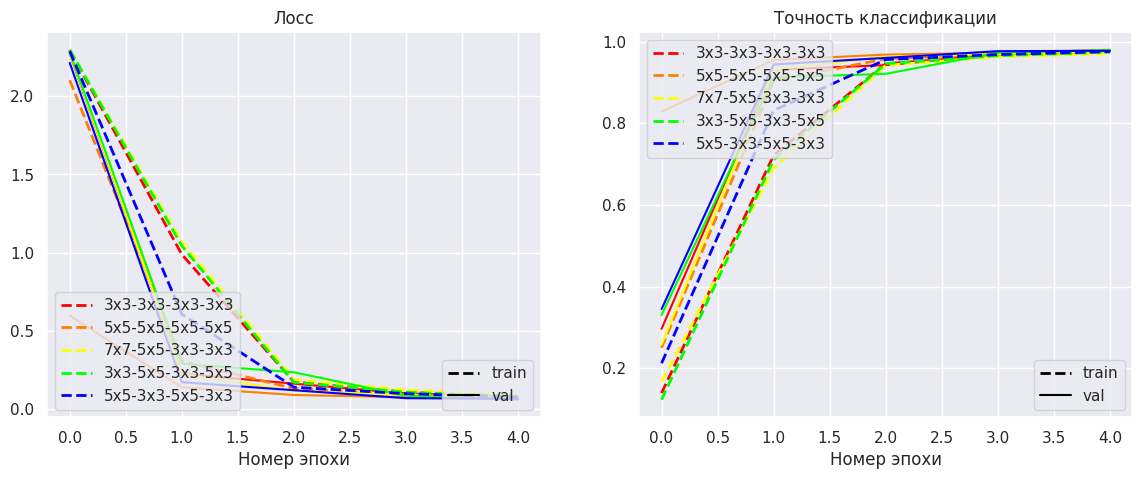

In [ ]:
plot_histories(histories, model_names)

посмотрим на итоговые точности

In [ ]:
print("Итоговая точность моделей:")
print("=" * 40)
for i, (name, history) in enumerate(zip(model_names, histories)):
    # Получаем последнее значение точности на валидации
    final_val_accuracy = history['acc']['val'][-1] * 100
    # Получаем последнее значение точности на обучении
    final_train_accuracy = history['acc']['train'][-1] * 100
    # Получаем последнее значение потерь на валидации
    final_val_loss = history['loss']['val'][-1]

    print(f"Модель: {name}")
    print(f"  Точность на валидации: {final_val_accuracy:.2f}%")
    print(f"  Точность на обучении: {final_train_accuracy:.2f}%")
    print("-" * 40)

Итоговая точность моделей:
Модель: 3x3-3x3-3x3-3x3
  Точность на валидации: 97.59%
  Точность на обучении: 97.44%
----------------------------------------
Модель: 5x5-5x5-5x5-5x5
  Точность на валидации: 98.05%
  Точность на обучении: 97.74%
----------------------------------------
Модель: 7x7-5x5-3x3-3x3
  Точность на валидации: 97.67%
  Точность на обучении: 97.10%
----------------------------------------
Модель: 3x3-5x5-3x3-5x5
  Точность на валидации: 97.98%
  Точность на обучении: 97.46%
----------------------------------------
Модель: 5x5-3x3-5x5-3x3
  Точность на валидации: 97.79%
  Точность на обучении: 97.60%
----------------------------------------


Из графика видно, что наилучшие предсказания делает модель с одинаковым ядрами 5х5, кроме того она и быстрее всех обучается. Вероятнее всего это происходит потому, что такой размер ядра оптимален для данной задачи (не слишком маленький для точности предсказаний и не слишком большой для времени обучения).\
Хуже всего себя показали модели с чередующимися размерами ядер и с слишком мальниким ядрами.

возьмем модель которая казала себя лучше всего (предыдущий блок кода выполнялся слишком долго и проще обучить заново)

In [ ]:
model = CNN5KernelVariations(kernel_sizes=[(5,5), (5,5), (5,5), (5,5)])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(5):  # Обычно хватает 5 эпох
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


сделаем дополнительный проход

In [ ]:
# 1. Переводим модель в режим оценки
model.eval()

# 2. Собираем предсказания и ошибки на валидационном наборе
all_preds = []
all_labels = []
misclassified = []
misclassified_indices = []  # Для сохранения индексов ошибок

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Сохраняем примеры ошибок с дополнительной информацией
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append({
                    'image': images[i].squeeze().cpu().numpy(),
                    'true': labels[i].item(),
                    'pred': preds[i].item(),
                    'batch_idx': batch_idx,
                    'sample_idx': i
                })
                misclassified_indices.append((batch_idx, i))


теперь проведем анализ предсказаний

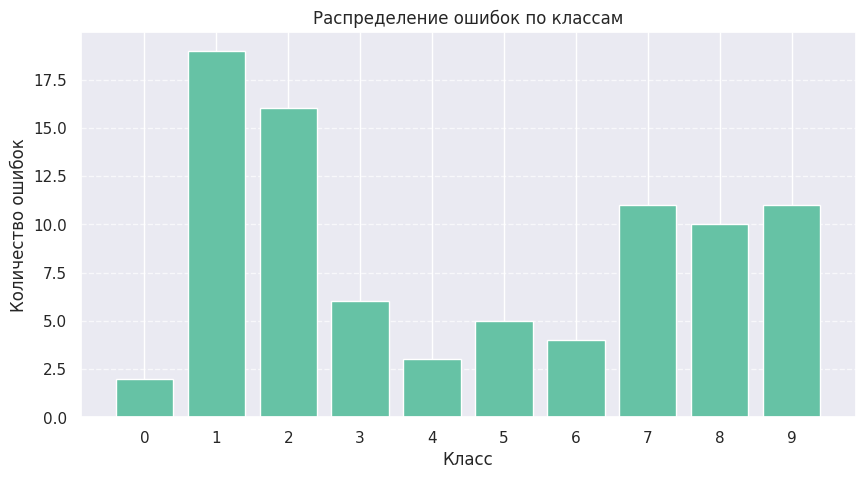


Всего ошибок: 87


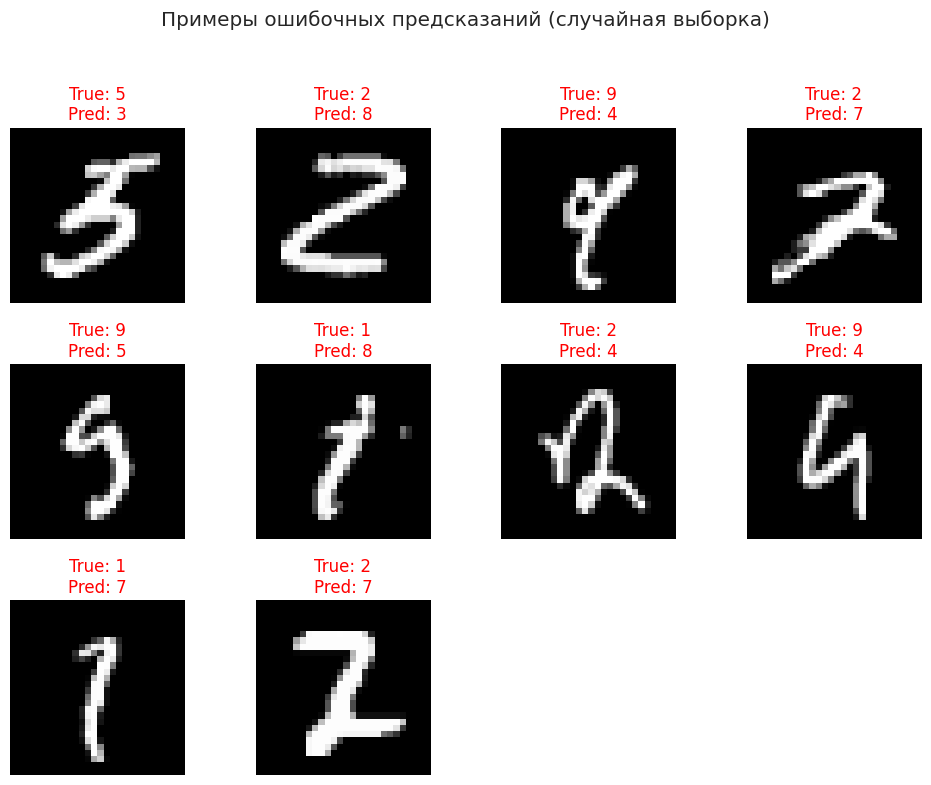


Дополнительная статистика:
Общая точность: 99.13%
Средняя точность по классам: 99.15%
Класс с наибольшим количеством ошибок: 1 (19.0 ошибок)


In [ ]:
# Анализ распределения ошибок
error_distribution = np.zeros(10)
for item in misclassified:
    error_distribution[item['true']] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(10), error_distribution)
plt.xticks(range(10))
plt.xlabel('Класс')
plt.ylabel('Количество ошибок')
plt.title('Распределение ошибок по классам')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Визуализация 10 случайных ошибок
print(f"\nВсего ошибок: {len(misclassified)}")
plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(len(misclassified), size=10, replace=False)):
    example = misclassified[idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(example['image'], cmap='gray')
    plt.title(f"True: {example['true']}\nPred: {example['pred']}", color='red')
    plt.axis('off')
plt.suptitle('Примеры ошибочных предсказаний (случайная выборка)', y=1.02)
plt.tight_layout()
plt.show()


# Статистика по типам ошибок
error_pairs = {}
for item in misclassified:
    pair = (item['true'], item['pred'])
    error_pairs[pair] = error_pairs.get(pair, 0) + 1


# 8. Дополнительная информация
print("\nДополнительная статистика:")
print(f"Общая точность: {100 * np.mean(np.array(all_labels) == np.array(all_preds)):.2f}%")
print(f"Средняя точность по классам: {100 * np.mean([cm[i,i]/sum(cm[i]) if sum(cm[i]) > 0 else 0 for i in range(10)]):.2f}%")
print(f"Класс с наибольшим количеством ошибок: {np.argmax(error_distribution)} ({np.max(error_distribution)} ошибок)")

Мы видим, что распределение ошибок по классам совсем не равномерное. Наиболее часто модель ошибается в угадывании единиц и двоек. Лучше всего она различает нули и четверки.\
Посмотрев на случайную выоъборку ошибок можно сказать, что эти цифры действительно сложно различить даже человеческому глазу (например на некотороый из примеров я сам ответил неправильно), так что ошибки в данном случае можно считать простительными